# 6.6 Sourcing & Analyzing Time Series Data
## Table of Contents:
### 1. Importing libraries and dataset
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Zillow Data

### 1. Importing libraries and dataset

In [9]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') 

In [10]:
# Configure API key 

quandl.ApiConfig.api_key = 'v5vrGyQXd4noqUH5BUKY'

In [11]:
# Importing the Zillow Housing Data.

data = quandl.get_table('ZILLOW/DATA')

In [12]:
data.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-03-31,468800.651793
1,ZSFH,99999,2024-02-29,469271.274647
2,ZSFH,99999,2024-01-31,472946.275728
3,ZSFH,99999,2023-12-31,476767.127006
4,ZSFH,99999,2023-11-30,480056.167658


### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# drop unnecessary columns

data=data.drop(columns=['indicator_id','region_id'])

In [14]:
data.head()

,date,value
None,,
0,2024-03-31,468800.651793
1,2024-02-29,469271.274647
2,2024-01-31,472946.275728
3,2023-12-31,476767.127006
4,2023-11-30,480056.167658


In [15]:
data.tail()

,date,value
None,,
9995,2006-09-30,276005.208244
9996,2006-08-31,273947.794273
9997,2006-07-31,270211.120233
9998,2006-06-30,265855.321605
9999,2006-05-31,261064.009622


In [16]:
data['date'].value_counts(dropna = False)

date
2015-05-31    40
2014-12-31    40
2016-05-31    40
2016-04-30    40
2016-03-31    40
              ..
1997-02-28     7
1997-03-31     7
1997-05-31     7
1997-06-30     7
1996-01-31     7
Name: count, Length: 339, dtype: int64

In [18]:
# Create a datetime column from "Date.""

data['date']=pd.to_datetime(data['date'], format='%d/%m/%Y')

In [19]:
# Set the "Date" column as the index

data=data.set_index('date')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2024-03-31 to 2006-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [21]:
data.shape

(10000, 1)

In [22]:
data.head()

,value
date,
2024-03-31,468800.651793
2024-02-29,469271.274647
2024-01-31,472946.275728
2023-12-31,476767.127006
2023-11-30,480056.167658


In [23]:
data=data[data.index < '2021-01-01']

In [24]:
# Resample data to monthly frequency 
data_monthly = data.resample('M').mean()

In [25]:
data_monthly.head()

,value
date,
1996-01-31,144105.857143
1996-02-29,144639.571429
1996-03-31,144922.000000
1996-04-30,145506.714286
1996-05-31,146361.571429


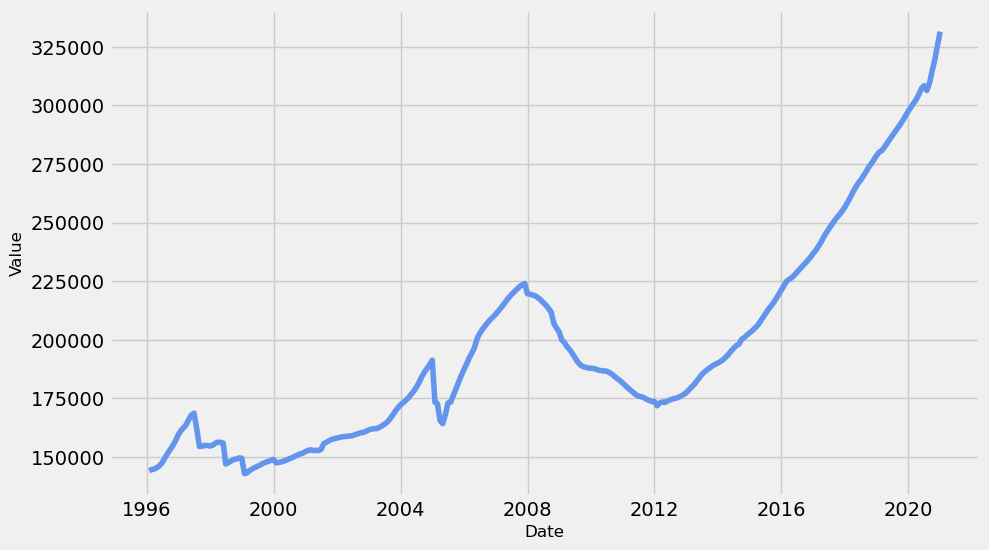

In [26]:
# Plot the data set

plt.figure(figsize = (10,6))
plt.plot(data_monthly, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.show()

In [27]:
# Check for missing values 

data_monthly.isnull().sum() 

value    0
dtype: int64

In [28]:
# Check for duplicates

dups = data_monthly.duplicated()
dups.sum()

0

### 3. Time series analysis: decomposition

In [29]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_monthly, model='additive')

In [30]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

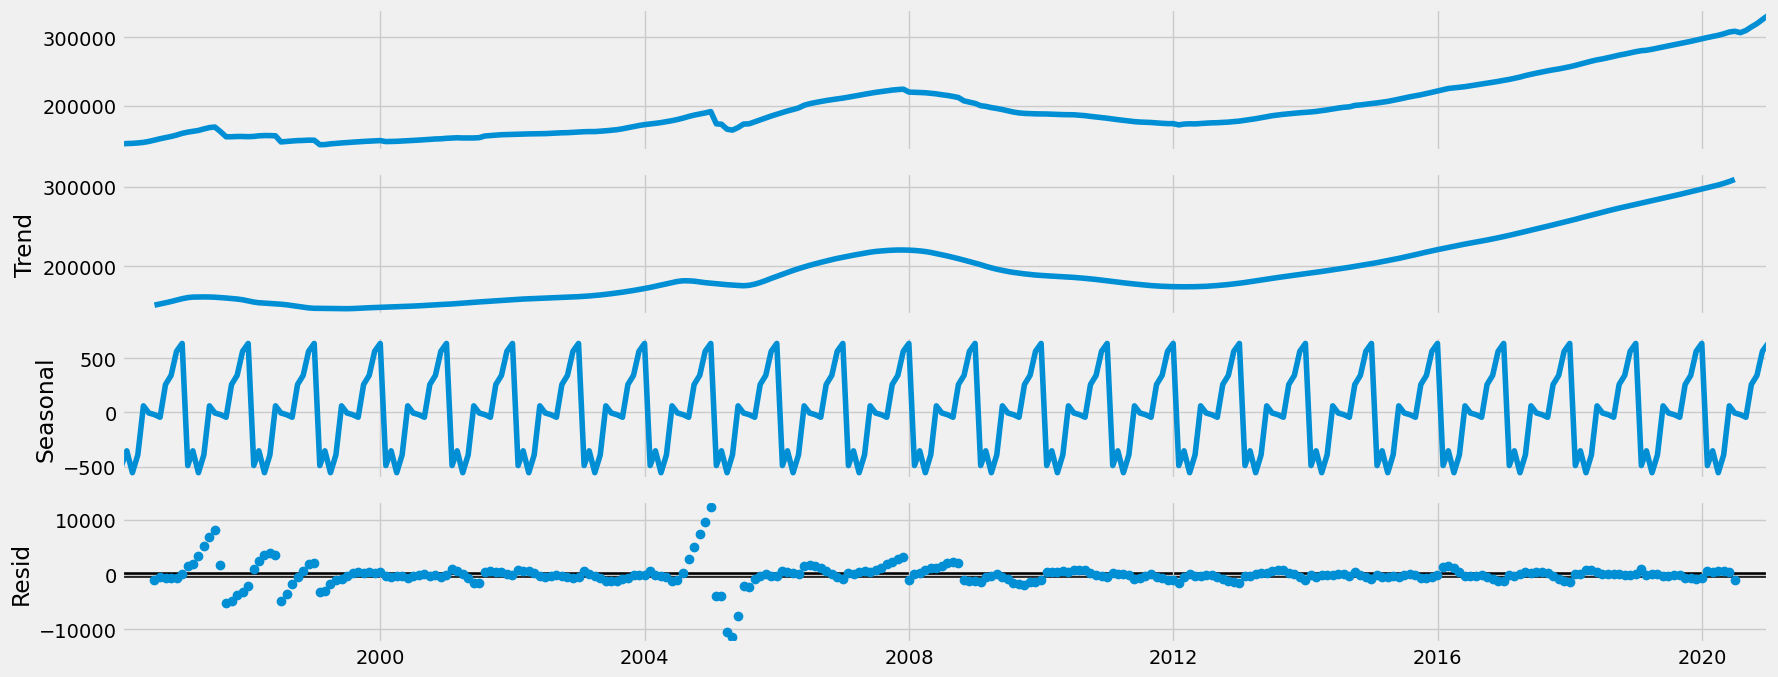

In [31]:
# Plot the separate components

decomposition.plot()
plt.show()

##### - From the grafic plot I can see that there is a trend of increase of the housing market, with a slight drop in 2005 and decrease from 2008 until 2013, which can be explained by the exonomical crisis. This seasolanlity line with the consistent curves shows there is seasonality. As the data has not been smoothed, the noice is in line with the level (the first line of the plot).

### 4. Testing for stationarity

In [32]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_monthly['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.355343
p-value                          0.998988
Number of Lags Used              2.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64


##### The critical value of 5% is much smaller than the test statistic, which means that this time series are non-stationary
##### Also the p - value of 0.996854 shows that the test result is not significant.

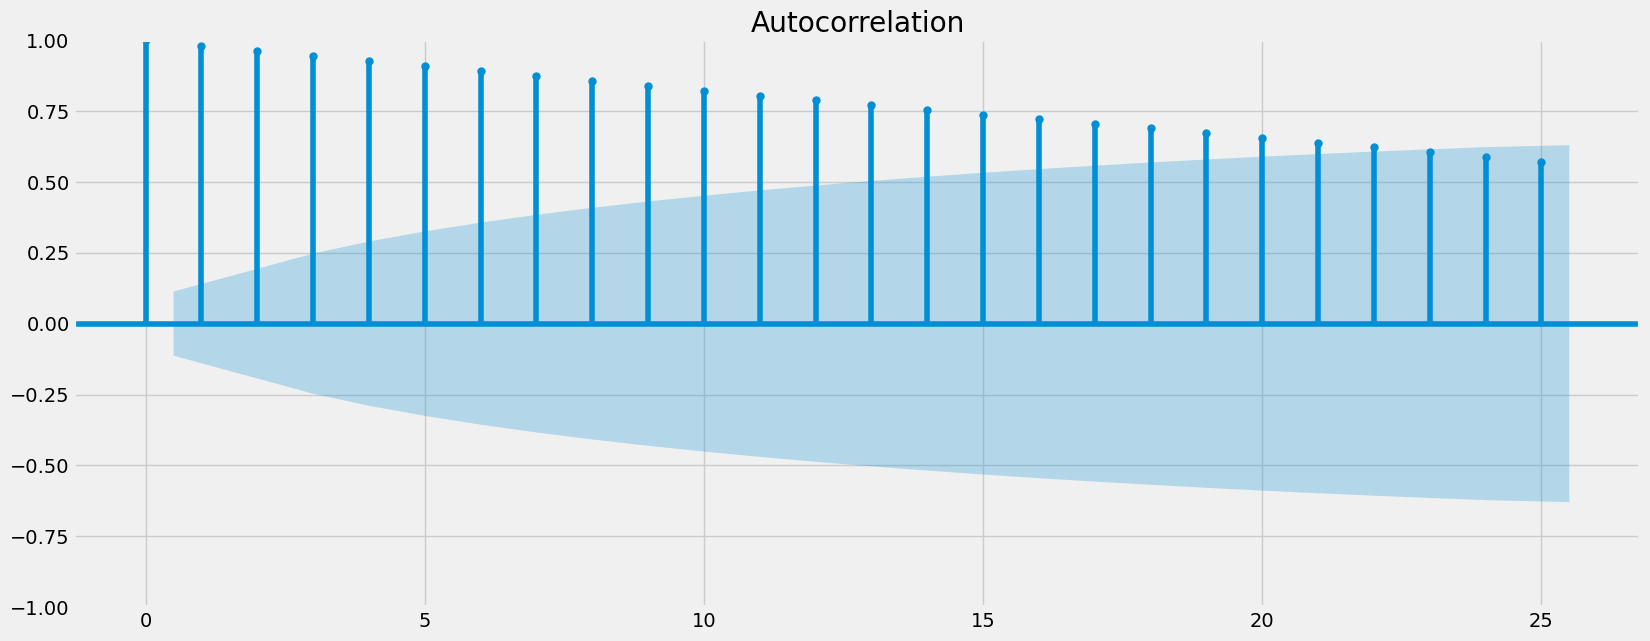

In [33]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_monthly)
plt.show()

##### The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means the lags are significantly correlated with each other. We have many lags beyond this interval, and can conclude that this data is non-stationary.

### 5. Stationarizing the Zillow Data

In [34]:
data_diff = data_monthly - data_monthly.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [35]:
# Removing the missing values that came about as a result of the differencing:

data_diff.dropna(inplace = True) 

In [36]:
data_diff.head()

,value
date,
1996-02-29,533.714286
1996-03-31,282.428571
1996-04-30,584.714286
1996-05-31,854.857143
1996-06-30,1339.285714


In [37]:
data_diff.columns

Index(['value'], dtype='object')

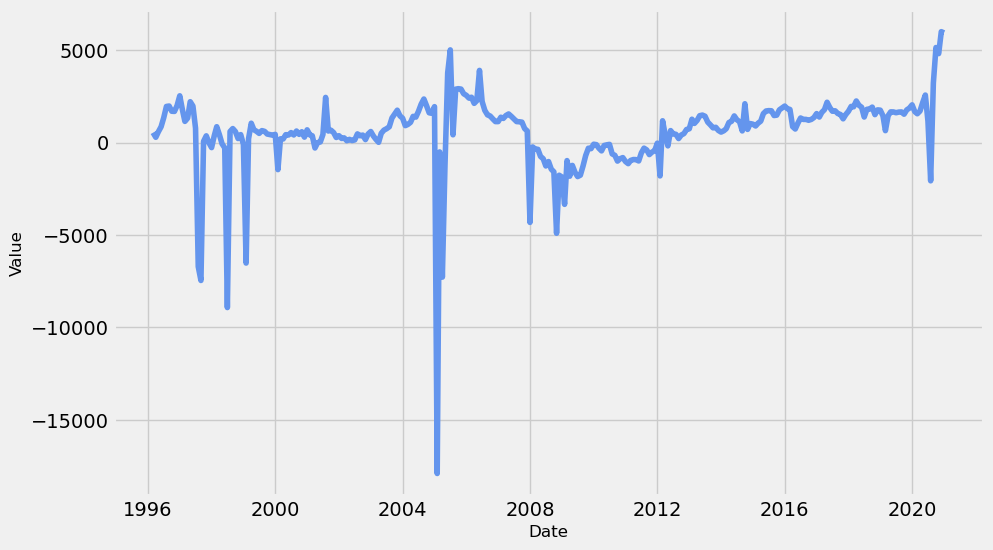

In [38]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize = (10,6))
plt.plot(data_diff, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.show()

In [39]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.792962e+00
p-value                        2.339278e-09
Number of Lags Used            1.000000e+00
Number of Observations Used    2.970000e+02
Critical Value (1%)           -3.452561e+00
Critical Value (5%)           -2.871321e+00
Critical Value (10%)          -2.571982e+00
dtype: float64


##### After Stationarizing the Zillow time series data using the Differencing method I found that the test statistic is now smaller than the critical value at both the five and ten percent significance levels. This means I can consider the time series stationary

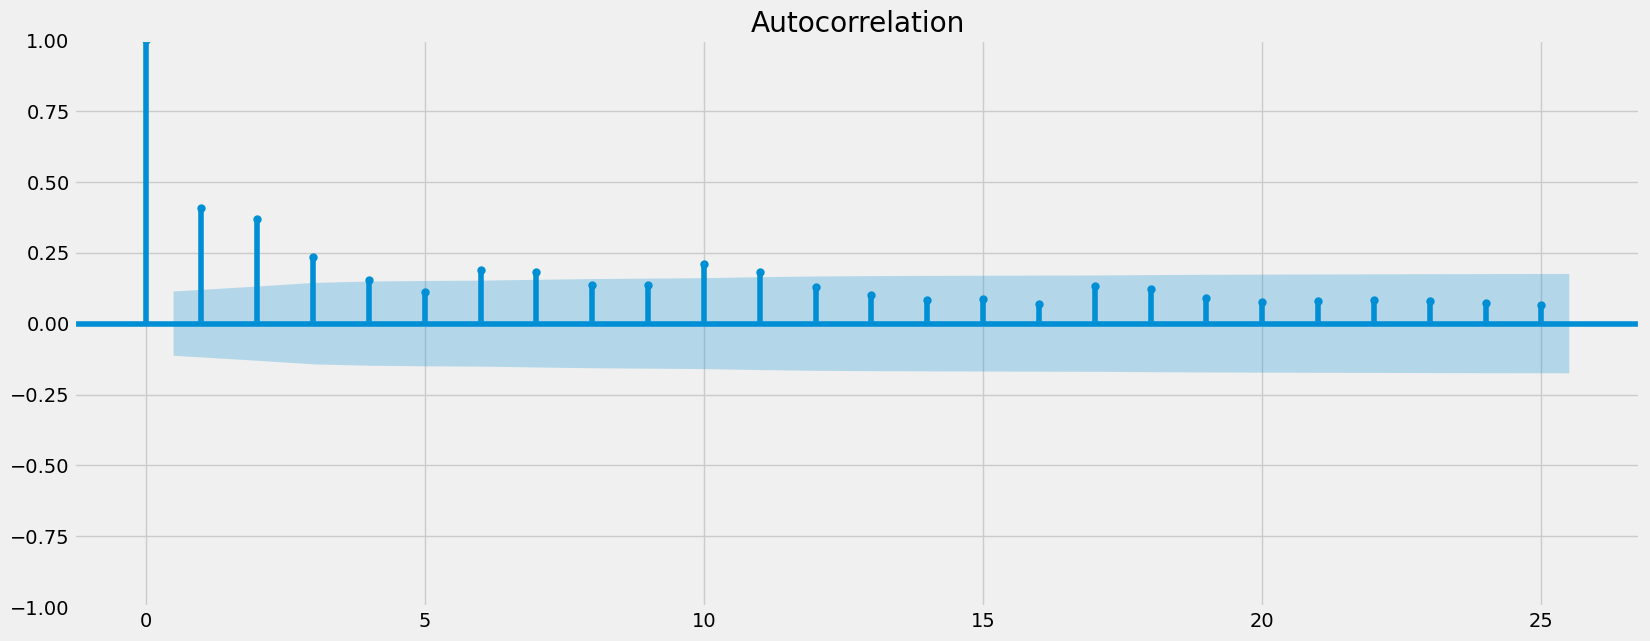

In [40]:
plot_acf(data_diff)
plt.show()

##### While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that data is stationary, the stationarity is weak.